# Detector Training using Detectron2

In [2]:
import os
import json
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Detectron2
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

### Data

In [3]:
root = '../split'
ann_file = 'coco/instances_default_6_modified.json'

register_coco_instances('hp_train', {}, ann_file, root)
register_coco_instances('hp_test', {}, 'coco/instances_default_5_modified.json', '../split')

dataset_metadata = MetadataCatalog.get('hp_train')
dataset_dicts = DatasetCatalog.get("hp_train")
dataset_metadata = MetadataCatalog.get('hp_test')
dataset_dicts = DatasetCatalog.get("hp_test")

### Model Training/Fine Tuning

- For more details, refer to Detectron Workflow notebook

In [9]:
# Model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))  # Faster R-CNN Model
cfg.DATASETS.TRAIN = ('hp_train',) # Train Dataset
cfg.DATASETS.TEST = ()  # Test Dataset Not Using Temporarily
cfg.DATALOADER.NUM_WORKERS = 2  # CPU Thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Weights from Model Zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch Size
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 1000  # Maximum Iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Num of Classes

In [10]:
# Train
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)  # Make Output Directory
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/16 21:18:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[11/16 21:18:19 d2.engine.train_loop]: Starting training from iteration 0
[11/16 21:18:33 d2.utils.events]:  eta: 0:06:21  iter: 19  total_loss: 1.105  loss_cls: 0.8025  loss_box_reg: 0.1146  loss_rpn_cls: 0.1421  loss_rpn_loc: 0.01465    time: 0.3832  last_time: 0.3189  data_time: 0.2906  last_data_time: 0.0009   lr: 4.9953e-06  max_mem: 1894M
[11/16 21:18:40 d2.utils.events]:  eta: 0:06:07  iter: 39  total_loss: 0.9365  loss_cls: 0.7216  loss_box_reg: 0.1024  loss_rpn_cls: 0.08619  loss_rpn_loc: 0.01276    time: 0.3785  last_time: 0.3853  data_time: 0.0016  last_data_time: 0.0011   lr: 9.9902e-06  max_mem: 1894M
[11/16 21:18:47 d2.utils.events]:  eta: 0:05:49  iter: 59  total_loss: 0.8649  loss_cls: 0.5867  loss_box_reg: 0.1202  loss_rpn_cls: 0.1013  loss_rpn_loc: 0.01268    time: 0.3719  last_time: 0.3223  data_time: 0.0044  last_data_time: 0.0012   lr: 1.4985e-05  max_mem: 1894M
[11/16 21:18:54 d2.utils.events]:  eta: 0:05:31  iter: 79  total_loss: 0.7893  loss_cls: 0.4616  loss_bo

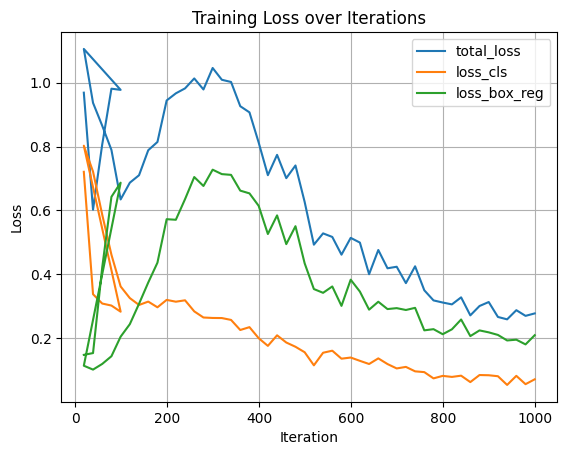

In [11]:
metrics_path = "output/metrics.json"

total_loss_values = []
cls_loss_values = []
box_reg_loss_values = []
iterations = []

with open(metrics_path, "r") as f:
    for line in f:
        data = json.loads(line)
        if "total_loss" in data: 
            iterations.append(data["iteration"])
            total_loss_values.append(data["total_loss"])
            cls_loss_values.append(data.get("loss_cls", 0))
            box_reg_loss_values.append(data.get("loss_box_reg", 0))

plt.plot(iterations, total_loss_values, label="total_loss")
plt.plot(iterations, cls_loss_values, label="loss_cls")
plt.plot(iterations, box_reg_loss_values, label="loss_box_reg")

plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [12]:
# Load model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Learned Model Weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Prediction Threshold
predictor = DefaultPredictor(cfg)

[11/16 21:25:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, m

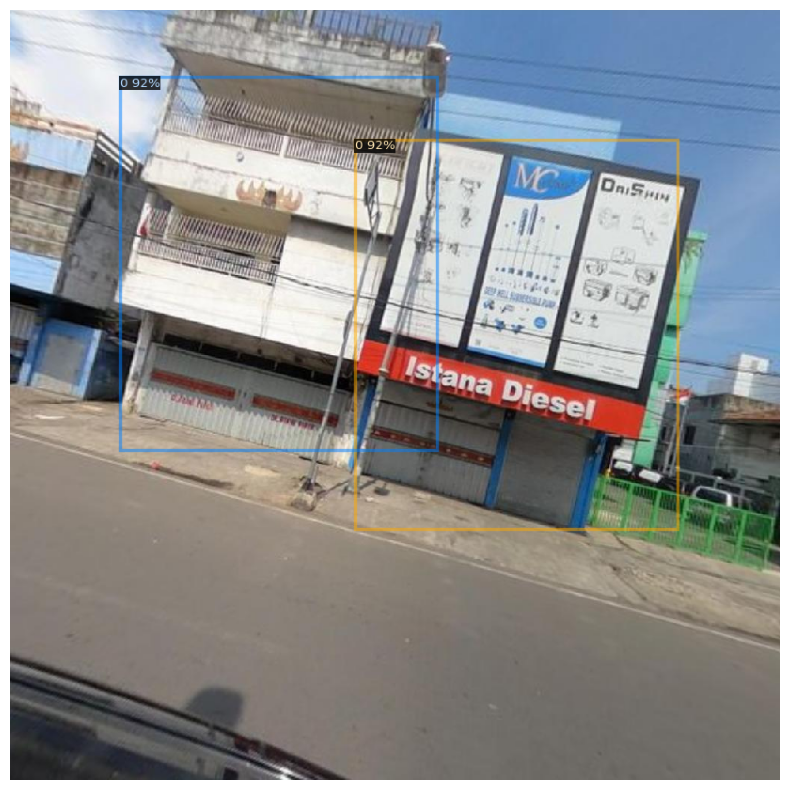

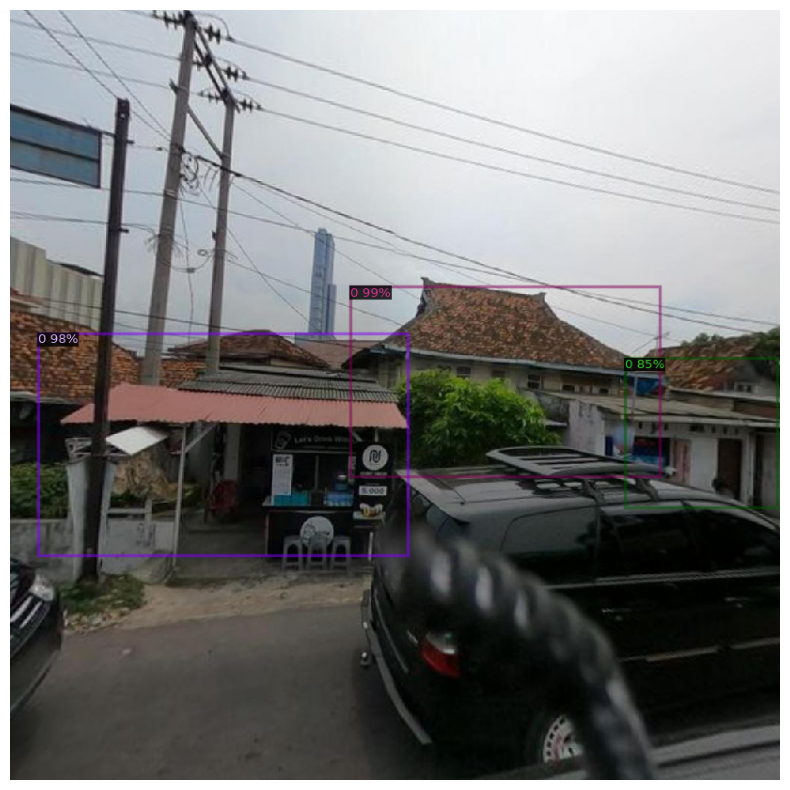

In [14]:
# Sample Images
img_paths = [
    '../split/814628423212932_left.jpg',
    '../split/823664802031496_right.jpg'
]

for path in img_paths:

    im = cv2.imread(path)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Convert RGB

    # Predict
    outputs = predictor(im)
    v = Visualizer(im_rgb[:, :, ::-1], metadata=MetadataCatalog.get("my_dataset_train"), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    output_image = out.get_image()[:, :, ::-1]

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

## Predictions on New Images